### Primordial Black Holes with pyHalo

In [1]:
from pyHalo.preset_models import CDM
import numpy as np
import matplotlib.pyplot as plt
from pyHalo.realization_extensions import RealizationExtensions
from pyHalo.utilities import interpolate_ray_paths
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions

plt.rcParams['axes.linewidth'] = 2.5
plt.rcParams['xtick.major.width'] = 3.5
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 6
plt.rcParams['ytick.minor.size'] = 6
plt.rcParams['ytick.major.width'] = 3.5
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20

### The following cells require installation of the package quadmodel (https://github.com/dangilman/quadmodel)

0.5 2.0


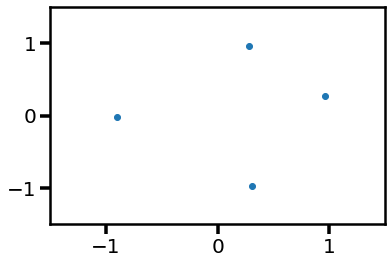

In [2]:
from quadmodel.data.mock_lenses.mock_2 import Mock2 as Mock
from quadmodel.quad_model import QuadLensSystem
from quadmodel.macromodel import MacroLensModel

mock_lens = Mock()
plt.scatter(mock_lens.x, mock_lens.y)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
zlens, zsource = mock_lens.zlens, mock_lens.zsource
print(zlens, zsource)
cdm_realization = CDM(zlens, zsource)
model, constrain_params_macro, optimization_routine, _, _ = mock_lens.generate_macromodel()
macromodel = MacroLensModel(model.component_list)
lens_system = QuadLensSystem.shift_background_auto(mock_lens, macromodel, zsource, cdm_realization)

In [3]:
from quadmodel.Solvers.hierachical import HierarchicalOptimization

opt = HierarchicalOptimization(lens_system, kwargs_settings_class={'log_mass_cut_global': 6.5})
kwargs_lens_final, lens_model_full, return_kwargs = opt.optimize(mock_lens, constrain_params=constrain_params_macro,
                                                                 param_class_name=optimization_routine, verbose=True)


optimization 1
aperture size (front):  100
aperture size (back):  100
log10 minimum mass anywhere (front):  7
log10 minimum mass anywhere (back):  12
log10 minimum mass in aperture (front):  7
log10 minimum mass in aperture (back):  12
N foreground halos:  94
N subhalos:  487
N background halos:  0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
Max iteration reached! Stopping.
PSO done... 
source plane chi^2:  2938623.2326339553
total chi^2:  2938623.2326339553
starting amoeba... 
optimization done.
Recovered source position:  (array([0.04011416, 0.0413416 , 0.04085878, 0.04083904]), array([-0.0209993 , -0.02083973, -0.0211894 , -0.02009037]))
aperture size (front):  0.3
aperture size (back):  100
log10 minimum mass anywhere (front):  7
log10 minimum mass anywhere (back):  7
log10 minimum mass in aperture (front):  -10
log10 minimum mass in aperture (back):  7
N foreground halos:  127
N subhalos:  717
N

In [4]:
from lenstronomy.LightModel.light_model import LightModel

source_x, source_y = lens_model_full.ray_shooting(mock_lens.x[0], mock_lens.y[0], kwargs_lens_final)
light_model = LightModel(['GAUSSIAN'])
kwargs_light = [{'amp': 1.0, 'center_x': source_x, 'center_y': source_y, 'sigma': 0.0025}]
# source size (full width at half max) is ~50 pc
npix = 200
rmax = 0.075
_r = np.linspace(-rmax, rmax, npix)
xx, yy = np.meshgrid(_r, _r)
shape0 = xx.shape
betax, betay = lens_model_full.ray_shooting(xx.ravel() + mock_lens.x[0], yy.ravel()+mock_lens.y[0], kwargs_lens_final)
sb = light_model.surface_brightness(betax, betay, kwargs_light).reshape(shape0)

14.2


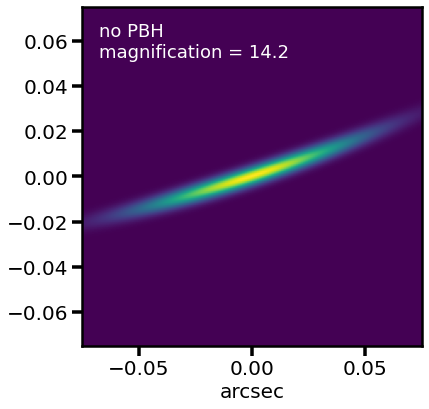

In [5]:
fig = plt.figure(1)
fig.set_size_inches(6,6)
mag = np.round(np.sum(sb) * (2*rmax/npix)**2, 1)
print(mag)
plt.imshow(sb, origin='lower', extent=[-rmax, rmax, -rmax, rmax])
plt.annotate('no PBH\nmagnification = '+str(mag), xy=(0.05, 0.85), xycoords='axes fraction', color='w', fontsize=18)
plt.xlabel('arcsec', fontsize=20)
plt.tight_layout()
plt.savefig('image_no_pbh.pdf')

In [6]:
npix = 200
rmax = 1.5

_r = np.linspace(-rmax, rmax, npix)
xx, yy = np.meshgrid(_r, _r)
shape0 = xx.shape
kappa = lens_model_full.kappa(xx.ravel(), yy.ravel(), kwargs_lens_final).reshape(shape0)
lensmodel_macro, kwargs_macro = lens_system.get_lensmodel(include_substructure=False)
kappa_macro = lensmodel_macro.kappa(xx.ravel(), yy.ravel(), kwargs_macro).reshape(shape0)
extent = [-rmax, rmax, -rmax, rmax]
residual_kappa_no_pbh = kappa - kappa_macro
lens_model_extension = LensModelExtensions(lens_model_full)
grid_resolution = 0.03 # this can take a while for higher resolution computations of the critical curves
ra_crit_list_nopbh, dec_crit_list_nopbh, _, _ = lens_model_extension.critical_curve_caustics(kwargs_lens_final, 
                                                                compute_window=2*rmax, grid_scale=grid_resolution)

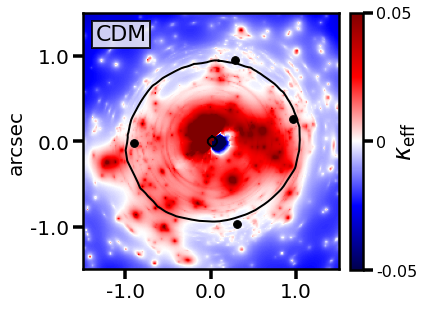

In [7]:
fig = plt.figure(1)
fig.set_size_inches(6,6)
inds = np.where(np.hypot(xx.ravel(), yy.ravel())>0.1)[0]
avg = np.mean(residual_kappa_no_pbh.ravel()[inds])
im=plt.imshow(residual_kappa_no_pbh - avg, 
           origin='lower', vmin=-0.05, vmax=0.05, cmap='seismic', extent=extent)
plt.scatter(mock_lens.x, mock_lens.y, color='k', s=60)

for i in range(0, len(ra_crit_list_nopbh)):
    plt.plot(ra_crit_list_nopbh[i], dec_crit_list_nopbh[i], color='k', lw=2)
    
cbar = fig.colorbar(im,orientation='vertical',aspect=20,fraction=0.046, pad=0.04)
cbar.set_label(r'$\kappa_{\rm{eff}}$',labelpad=-24, fontsize=24)
cbar.set_ticks([-0.05, 0.0, 0.05])
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_yticklabels(['-0.05', '0', '0.05'], fontsize=16)

ax = plt.gca()
ax.set_xticks([-1.0, 0.0, 1.0])
ax.set_xticklabels([-1.0, 0.0, 1.0], fontsize=20)
ax.set_yticks([-1.0, 0.0, 1.0])
ax.set_yticklabels([-1.0, 0.0, 1.0], fontsize=20)
ax.set_ylabel('arcsec', fontsize=20)

t = ax.text(
    -1.05, 1.25, 'CDM', ha="center", va="center", size=22,
    bbox=dict(boxstyle="square,pad=0.15", fc="0.95", ec="k", lw=2,alpha=0.85))
plt.tight_layout()
plt.savefig('CDM_pbh.pdf')

In [8]:
pbh_mass_fraction = 0.2
log_black_hole_mass = 6.0
kwargs_pbh_mass_function = {'mass_function_type': 'DELTA', 'logM': log_black_hole_mass}
mass_fraction_in_halos = 0.5

x_image_interp_list, y_image_interp_list = interpolate_ray_paths(mock_lens.x,
                                                                 mock_lens.y,
                                                                 lens_model_full,
                                                                 kwargs_lens_final, 
                                                                 zsource)
aperture_sizes = [0.25] * len(mock_lens.x)
n_cdm_halos = len(lens_system.realization.halos)
ext = RealizationExtensions(lens_system.realization)
pbh_realization = ext.add_primordial_black_holes(pbh_mass_fraction, kwargs_pbh_mass_function,
                                                         mass_fraction_in_halos,
                                                         x_image_interp_list, y_image_interp_list, aperture_sizes)
n_pbh = len(pbh_realization.halos) - n_cdm_halos
print('added '+str(n_pbh)+' PBH...')
lens_system_pbh = QuadLensSystem.addRealization(lens_system, pbh_realization)
print('re-fitting lens model... ')
lens_system_pbh.initialize(mock_lens, opt_routine=optimization_routine,
                                       constrain_params=constrain_params_macro,
                                       verbose=True, include_substructure=True,
                                       kwargs_optimizer={"re_optimize": True, "particle_swarm": False})
lens_model_full, kwargs_lens_final = lens_system_pbh.get_lensmodel()

added 1941 PBH...
re-fitting lens model... 
starting amoeba... 
optimization done.
Recovered source position:  (array([0.04252592, 0.04414334, 0.04353404, 0.04350904]), array([-0.02365719, -0.02346115, -0.02395036, -0.02241111]))


In [9]:
kappa = lens_model_full.kappa(xx.ravel(), yy.ravel(), kwargs_lens_final).reshape(shape0)
lensmodel_macro, kwargs_macro = lens_system.get_lensmodel(include_substructure=False)
kappa_macro = lensmodel_macro.kappa(xx.ravel(), yy.ravel(), kwargs_macro).reshape(shape0)
extent = [-rmax, rmax, -rmax, rmax]
residual_kappa_with_pbh = kappa - kappa_macro

lens_model_extension = LensModelExtensions(lens_model_full)
gridres = 0.1
ra_crit_list_with_pbh, dec_crit_list_with_pbh, _, _ = lens_model_extension.critical_curve_caustics(kwargs_lens_final, 
                                                                compute_window=2*rmax, grid_scale=gridres)

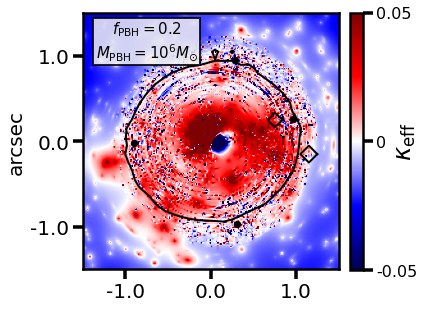

In [10]:
fig = plt.figure(1)
fig.set_size_inches(6,6)
inds = np.where(np.hypot(xx.ravel(), yy.ravel())>0.3)[0]
avg = np.mean(residual_kappa_with_pbh.ravel()[inds])
im=plt.imshow(residual_kappa_with_pbh - avg, 
           origin='lower', vmin=-0.05, vmax=0.05, cmap='seismic', extent=extent)
plt.scatter(mock_lens.x, mock_lens.y, color='k', s=40)
for i in range(0, len(ra_crit_list_with_pbh)):
    plt.plot(ra_crit_list_with_pbh[i], dec_crit_list_with_pbh[i], color='k', lw=2)
    
cbar = fig.colorbar(im,orientation='vertical',aspect=20,fraction=0.046, pad=0.04)
cbar.set_label(r'$\kappa_{\rm{eff}}$',labelpad=-24, fontsize=24)
cbar.set_ticks([-0.05, 0.0, 0.05])
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_yticklabels(['-0.05', '0', '0.05'], fontsize=16)

ax = plt.gca()
ax.set_xticks([-1.0, 0.0, 1.0])
ax.set_xticklabels([-1.0, 0.0, 1.0], fontsize=20)
ax.set_yticks([-1.0, 0.0, 1.0])
ax.set_yticklabels([-1.0, 0.0, 1.0], fontsize=20)
ax.set_ylabel('arcsec', fontsize=20)

t = ax.text(
    -0.75, 1.175, r'$f_{\rm{PBH}} = 0.2$'+'\n'+r'$M_{\rm{PBH}} = 10^{6} M_{\odot}$', ha="center", va="center", size=15,
    bbox=dict(boxstyle="square,pad=0.15", fc="0.95", ec="k", lw=2,alpha=0.85))

plt.tight_layout()
# plt.savefig('PBH.pdf')

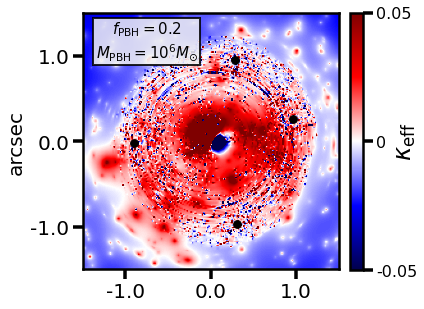

In [11]:
fig = plt.figure(1)
fig.set_size_inches(6,6)
inds = np.where(np.hypot(xx.ravel(), yy.ravel())>0.1)[0]
avg = np.mean(residual_kappa_with_pbh.ravel()[inds])
im=plt.imshow(residual_kappa_with_pbh - avg, 
           origin='lower', vmin=-0.05, vmax=0.05, cmap='seismic', extent=extent)
plt.scatter(mock_lens.x, mock_lens.y, color='k', s=60)
#for i in range(0, len(ra_crit_list_with_pbh)):
#    plt.plot(ra_crit_list_with_pbh[i], dec_crit_list_with_pbh[i], color='k', lw=2)
    
cbar = fig.colorbar(im,orientation='vertical',aspect=20,fraction=0.046, pad=0.04)
cbar.set_label(r'$\kappa_{\rm{eff}}$',labelpad=-24, fontsize=24)
cbar.set_ticks([-0.05, 0.0, 0.05])
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_yticklabels(['-0.05', '0', '0.05'], fontsize=16)

ax = plt.gca()
ax.set_xticks([-1.0, 0.0, 1.0])
ax.set_xticklabels([-1.0, 0.0, 1.0], fontsize=20)
ax.set_yticks([-1.0, 0.0, 1.0])
ax.set_yticklabels([-1.0, 0.0, 1.0], fontsize=20)
ax.set_ylabel('arcsec', fontsize=20)

t = ax.text(
    -0.75, 1.175, r'$f_{\rm{PBH}} = 0.2$'+'\n'+r'$M_{\rm{PBH}} = 10^{6} M_{\odot}$', ha="center", va="center", size=15,
    bbox=dict(boxstyle="square,pad=0.15", fc="0.95", ec="k", lw=2,alpha=0.85))

plt.tight_layout()
# plt.savefig('PBH_nocritcurves.pdf')

In [12]:
dr = 0.25
npix = 200
_r = np.linspace(-dr, dr, npix)
xx, yy = np.meshgrid(_r, _r)
img_index = 0
xx += mock_lens.x[img_index]
yy += mock_lens.y[img_index]
shape0 = xx.shape

kappa = lens_model_full.kappa(xx.ravel(), yy.ravel(), kwargs_lens_final).reshape(shape0)
lensmodel_macro, kwargs_macro = lens_system.get_lensmodel(include_substructure=False)
kappa_macro = lensmodel_macro.kappa(xx.ravel(), yy.ravel(), kwargs_macro).reshape(shape0)
extent = [-dr, dr, -dr, dr]
residual_kappa_with_pbh_local = kappa - kappa_macro

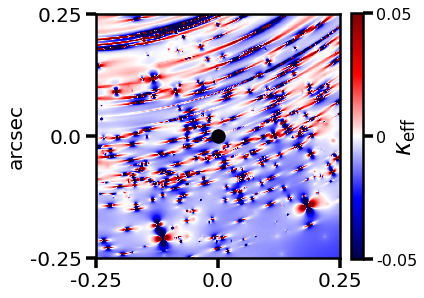

In [13]:
fig = plt.figure(1)
fig.set_size_inches(6,6)

im=plt.imshow(residual_kappa_with_pbh_local-np.mean(residual_kappa_with_pbh_local), 
           origin='lower', vmin=-0.05, vmax=0.05, cmap='seismic', extent=extent)
plt.scatter(0.0, 0.0, color='k', s=180)
   
cbar = fig.colorbar(im,orientation='vertical',aspect=20,fraction=0.046, pad=0.04)
cbar.set_label(r'$\kappa_{\rm{eff}}$',labelpad=-24, fontsize=24)
cbar.set_ticks([-0.05, 0.0, 0.05])
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_yticklabels(['-0.05', '0', '0.05'], fontsize=16)

ax = plt.gca()
ax.set_xticks([-dr, 0.0, dr])
ax.set_xticklabels([-dr, 0.0, dr], fontsize=20)
ax.set_yticks([-dr, 0.0, dr])
ax.set_yticklabels([-dr, 0.0, dr], fontsize=20)
ax.set_ylabel('arcsec', fontsize=20)

plt.tight_layout()
# plt.savefig('PBH_local.pdf')

In [14]:
from lenstronomy.LightModel.light_model import LightModel

source_x, source_y = lens_model_full.ray_shooting(mock_lens.x[0], mock_lens.y[0], kwargs_lens_final)
light_model = LightModel(['GAUSSIAN'])
kwargs_light = [{'amp': 1.0, 'center_x': source_x, 'center_y': source_y, 'sigma': 0.0025}]

npix = 200
dr = 0.1
_r = np.linspace(-dr, dr, npix)
xx, yy = np.meshgrid(_r, _r)
shape0 = xx.shape
betax, betay = lens_model_full.ray_shooting(xx.ravel() + mock_lens.x[0], yy.ravel()+mock_lens.y[0], kwargs_lens_final)
sb_withpbh = light_model.surface_brightness(betax, betay, kwargs_light).reshape(shape0)

17.1


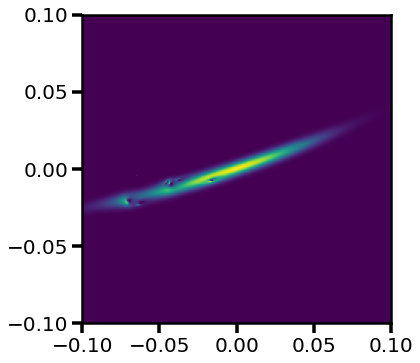

In [15]:
fig = plt.figure(1)
fig.set_size_inches(6,6)

mag = np.round(np.sum(sb_withpbh) * (2*dr/npix)**2, 1)
print(mag)
plt.imshow(sb_withpbh, origin='lower',extent=[-dr, dr, -dr, dr])
#plt.annotate('magnification = '+str(mag), xy=(0.05, 0.9), xycoords='axes fraction', color='w', fontsize=16)
plt.tight_layout()
# plt.savefig('image_with_pbh.pdf')